In [ ]:
pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 46.8 MB/s eta 0:00:00


In [ ]:
pip install alpha_vantage

In [ ]:
pip install yfinance

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for NVDA...
Data fetched: 1522 rows.
Index(['price', 'volume', 'ticker'], dtype='object')
Fetching data for BTC-USD...
Data fetched: 2215 rows.
Index(['price', 'volume', 'ticker'], dtype='object')
Epoch 1/10



C:\Users\Daniel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.0437e-04 - mse: 9.0437e-04 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.4614e-04 - mse: 8.4614e-04 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.5931e-04 - mse: 6.5931e-04 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.7796e-04 - mse: 7.7796e-04 - val_loss: 9.9265e-04 - val_mse: 9.9265e-04
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━

C:\Users\Daniel\AppData\Local\Temp\ipykernel_30412\1561838418.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  visualize_predictions(crypto_model, crypto_X, crypto_y, crypto_scaler, "Cryptocurrency Predictions", crypto_data.index[sequence_length:], crypto_data['ticker'][0])


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


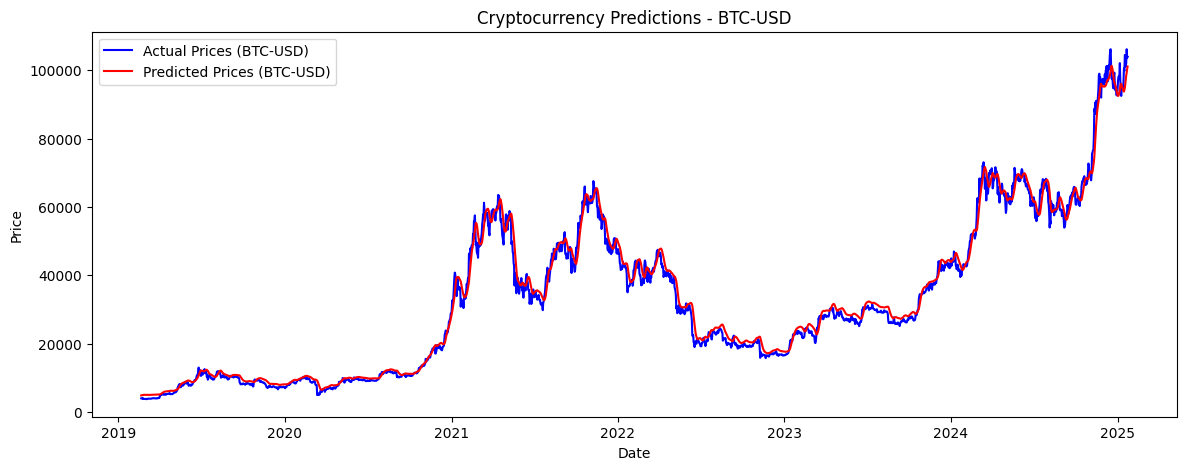

C:\Users\Daniel\AppData\Local\Temp\ipykernel_30412\1561838418.py:142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  visualize_predictions(stock_model, stock_X, stock_y, stock_scaler, "Stock Predictions", stock_data.index[sequence_length:], stock_data['ticker'][0])


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


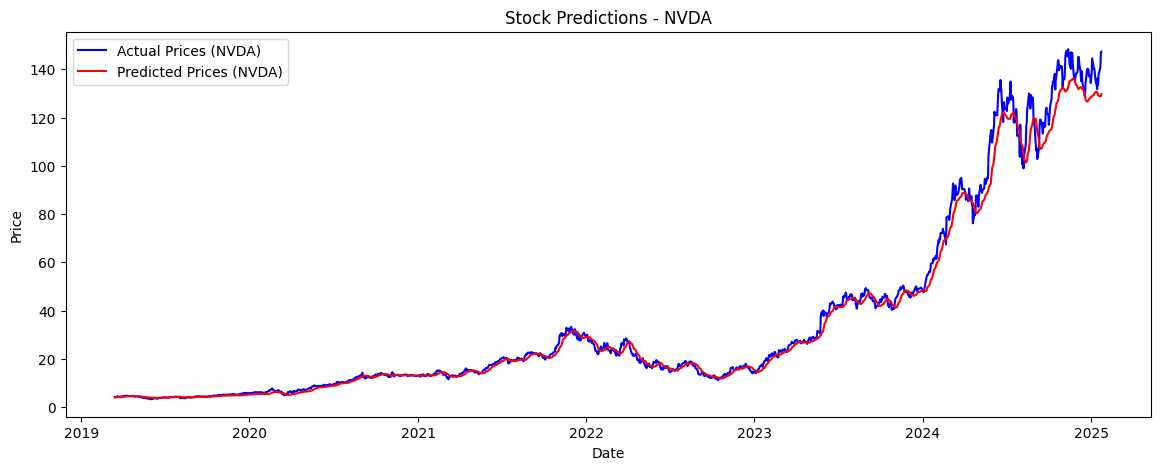

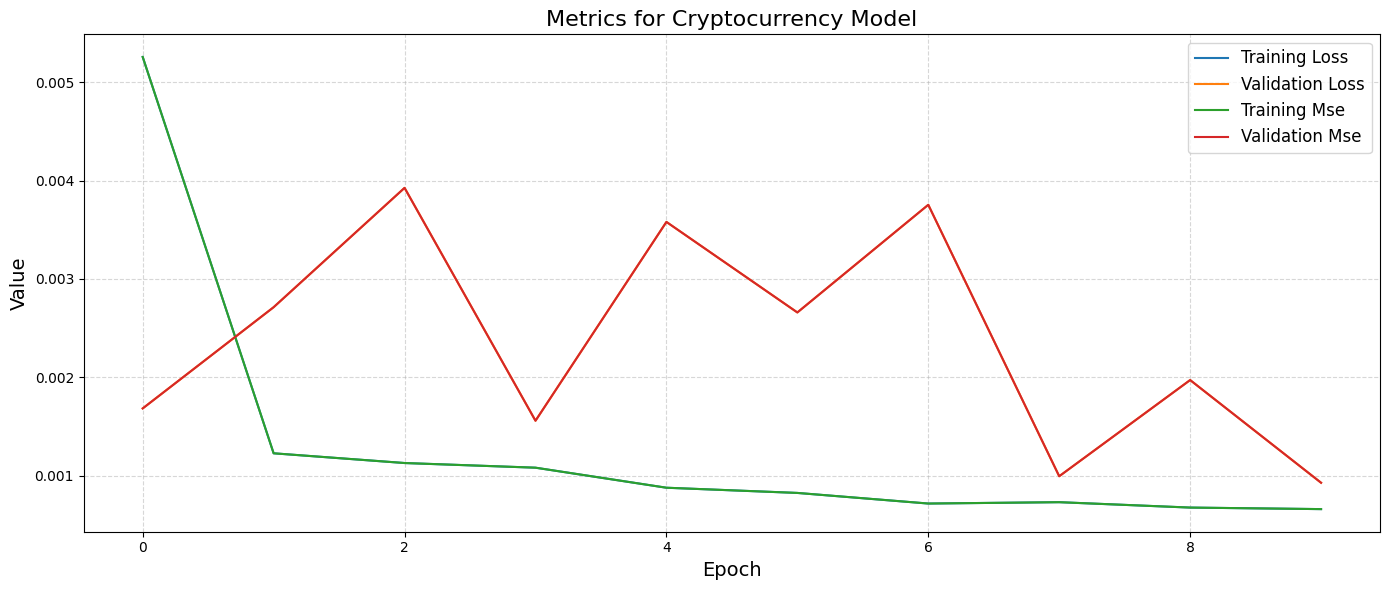

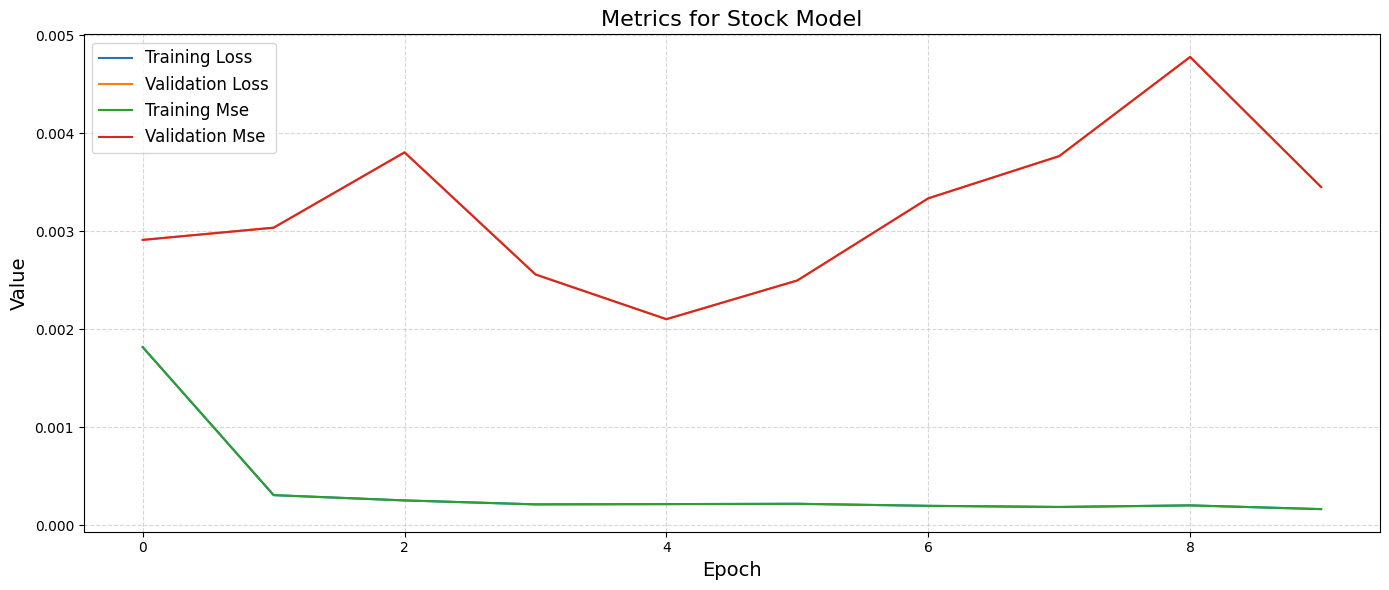

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import yfinance as yf

#step 1: data collection for crpyto and stocks
def fetch_crypto_data(ticker="BTC-USD", start_date='2019-01-01', end_date='2025-01-24'):
    print(f"Fetching data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError(f"No data found for {ticker}.")
    data = data[['Close', 'Volume']]
    data.columns = ['price', 'volume']
    data['ticker'] = ticker

    data.dropna(inplace=True)
    print(f"Data fetched: {data.shape[0]} rows.")

    return data

#obtiene datos históricos de acciones desde Yahoo Finance.
#filtra datos anómalos y rellena valores faltantes.
def fetch_stock_data(ticker="NVDA", start_date='2019-01-01', end_date='2025-01-24'):
    print(f"Fetching data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)

    if data.empty:
        raise ValueError(f"No data found for {ticker}.")

    #seleccionar columnas relevantes, como en la funciond anterior
    data = data[['Close', 'Volume']]
    data.columns = ['price', 'volume']
    data['ticker'] = ticker

    #rellenar valores faltantes
    data['price'] = data['price'].interpolate(method='linear', limit_direction='both')
    data['volume'] = data['volume'].interpolate(method='linear', limit_direction='both')

    #detectar y eliminar valores extremos
    z_scores = (data['price'] - data['price'].mean()) / data['price'].std()
    #z-scores ayuda a eliminar precios anomalos como caídas repentinas como pasaria con alpha vantage
    data = data[(z_scores.abs() < 3)]  #elimina valores con z-score > 3

    #eliminar duplicados
    data = data[~data.index.duplicated(keep='first')]

    #dropna final por seguridad
    data.dropna(inplace=True)

    print(f"Data fetched: {data.shape[0]} rows.")
    return data
    
#fetch stock data and print column names
stock_data = fetch_stock_data()
print(stock_data.columns)

#example:fetch data for multiple asset types
crypto_data = fetch_crypto_data()
print(crypto_data.columns)

#step 2:preprocessing
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

#separate preprocessing per asset type
crypto_scaled, crypto_scaler = preprocess_data(crypto_data[['price']])
stock_scaled, stock_scaler = preprocess_data(stock_data[['price']])

#create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(sequence_length, len(data)):
        sequences.append(data[i-sequence_length:i, :])
        labels.append(data[i, 0])
    return np.array(sequences), np.array(labels)

sequence_length = 50
crypto_X, crypto_y = create_sequences(crypto_scaled, sequence_length)
stock_X, stock_y = create_sequences(stock_scaled, sequence_length)

#step 3: lstm model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    return model

crypto_model = build_lstm_model((crypto_X.shape[1], crypto_X.shape[2]))
stock_model = build_lstm_model((stock_X.shape[1], stock_X.shape[2]))

#train the models
crypto_history = crypto_model.fit(crypto_X, crypto_y, epochs=10, batch_size=32, validation_split=0.2)
stock_history = stock_model.fit(stock_X, stock_y, epochs=10, batch_size=32, validation_split=0.2)

def visualize_predictions(model, X_test, y_test, scaler, title, dates, asset_name):
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(14, 5))
    plt.plot(dates[-len(y_test):], y_test_rescaled, color='blue', label=f'Actual Prices ({asset_name})')
    plt.plot(dates[-len(y_test):], predictions_rescaled, color='red', label=f'Predicted Prices ({asset_name})')
    plt.title(f'{title} - {asset_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def visualize_metrics(history, title="Model Metrics"):
    #visualiza las metricas del modelo (perdida y cualquier otra metrica incluida en 'model.compile')
    #podria ser tanto mse como mae
    plt.figure(figsize=(14, 6))

    #graficar todas las métricas disponibles
    for metric in history.history.keys():
        if "val_" not in metric:  # Evitar duplicar métricas de validación
            plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')

    plt.title(title, fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5) 
    plt.tight_layout()
    plt.show()

visualize_predictions(crypto_model, crypto_X, crypto_y, crypto_scaler, "Cryptocurrency Predictions", crypto_data.index[sequence_length:], crypto_data['ticker'][0])
visualize_predictions(stock_model, stock_X, stock_y, stock_scaler, "Stock Predictions", stock_data.index[sequence_length:], stock_data['ticker'][0])

visualize_metrics(crypto_history, title="Metrics for Cryptocurrency Model")
visualize_metrics(stock_history, title="Metrics for Stock Model")